In [1]:
!pip install -q sentence-transformers pandas numpy scikit-learn


In [2]:
import pandas as pd
from collections import defaultdict
from sklearn.preprocessing import MinMaxScaler

from google.colab import files
uploaded = files.upload()


train_df = pd.read_csv("dataset_training.csv")
test_df = pd.read_csv("student_emotion_dataset_test_20k_balanced.csv")


Saving dataset_training.csv to dataset_training.csv
Saving student_emotion_dataset_test_20k_balanced.csv to student_emotion_dataset_test_20k_balanced.csv


In [3]:
def add_history_features(df, history_counter=None):
    if history_counter is None:
        history_counter = defaultdict(int)
    history_counts = []
    for _, row in df.iterrows():
        key = f"{row['student_id']}_{row['subject']}"
        history_counts.append(history_counter[key])
        history_counter[key] += 1
    df['history_count'] = history_counts
    return df, history_counter

# Add to both train and test
train_df, history_counter = add_history_features(train_df)
test_df, _ = add_history_features(test_df, history_counter)

# Normalize history count
scaler = MinMaxScaler()
train_df['history_count_norm'] = scaler.fit_transform(train_df[['history_count']])
test_df['history_count_norm'] = scaler.transform(test_df[['history_count']])

In [ ]:
import numpy as np

# Difficulty map
difficulty_score_map = {'beginner': 0.2, 'intermediate': 0.5, 'advanced': 0.8}
urgency_score_map = {'low': 0.0, 'medium': 0.5, 'high': 1.0}

def get_score(row):
    difficulty_score = difficulty_score_map.get(row['difficulty_level'], 0.5)
    urgency_score = urgency_score_map.get(row['urgency_level'], 0.0)
    experience_score = 1 - row['history_count_norm']

    # Weighted sum
    score = (
        0.4 * difficulty_score +
        0.4 * urgency_score +
        0.2 * experience_score +
        np.random.normal(0, 0.1)  # Add noise
    )
    return score

def classify_strategy(row):
    score = get_score(row)
    if score >= 0.65:
        return 'RAG'
    elif score <= 0.35:
        return 'CAG'
    else:
        return 'Both'

train_df['strategy_label'] = train_df.apply(classify_strategy, axis=1)
test_df['strategy_label'] = test_df.apply(classify_strategy, axis=1)


In [ ]:
train_binary = train_df[train_df['strategy_label'] != 'Both']
test_binary = test_df[test_df['strategy_label'] != 'Both']

print("Training Label Distribution:")
print(train_binary['strategy_label'].value_counts())

print("\nTesting Label Distribution:")
print(test_binary['strategy_label'].value_counts())


Training Label Distribution:
strategy_label
CAG    26416
RAG    21639
Name: count, dtype: int64

Testing Label Distribution:
strategy_label
CAG    6697
RAG    5502
Name: count, dtype: int64


In [ ]:
!pip install -q sentence-transformers

from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
train_queries = train_binary['current_query'].astype(str).tolist()
test_queries = test_binary['current_query'].astype(str).tolist()

train_query_embeddings = model.encode(train_queries, show_progress_bar=True, batch_size=64)
test_query_embeddings = model.encode(test_queries, show_progress_bar=True, batch_size=64)


Batches:   0%|          | 0/751 [00:00<?, ?it/s]

Batches:   0%|          | 0/191 [00:00<?, ?it/s]

In [ ]:
import numpy as np

# Get numeric features
train_features = train_binary[['history_count_norm']].values
test_features = test_binary[['history_count_norm']].values

# Combine embeddings + numeric
X_train = np.hstack([train_query_embeddings, train_features])
X_test = np.hstack([test_query_embeddings, test_features])


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(train_binary['strategy_label'])
y_test = le.transform(test_binary['strategy_label'])

print("Classes:", le.classes_)


Classes: ['CAG' 'RAG']


In [ ]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation='relu',
    alpha=0.001,
    max_iter=500,
    random_state=42
)

clf.fit(X_train, y_train)


MLPClassifier(alpha=0.001, hidden_layer_sizes=(128, 64), max_iter=500,
              random_state=42)

Classification Report:

              precision    recall  f1-score   support

         CAG       0.96      0.96      0.96      6697
         RAG       0.95      0.95      0.95      5502

    accuracy                           0.95     12199
   macro avg       0.95      0.95      0.95     12199
weighted avg       0.95      0.95      0.95     12199



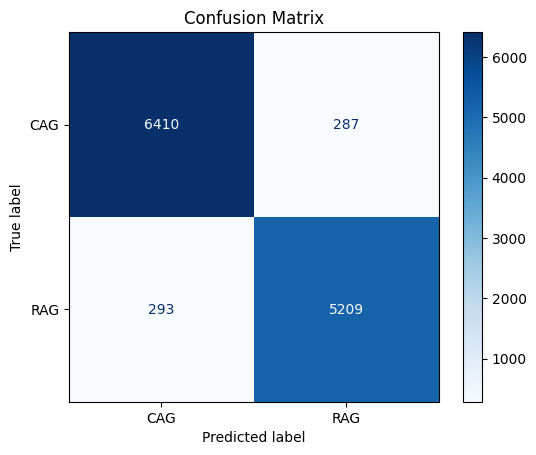

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict
y_pred = clf.predict(X_test)

# Evaluation
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


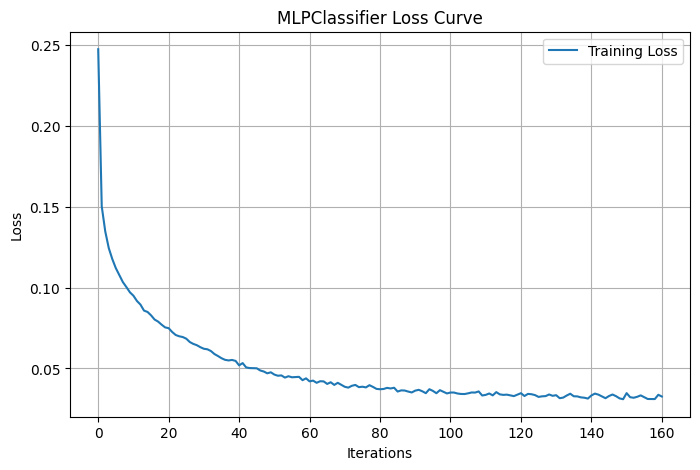

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(clf.loss_curve_, label='Training Loss')
plt.title("MLPClassifier Loss Curve")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()
